In [100]:
import numpy as np
import pandas as pd
import heapq
import concurrent.futures
import threading
import os 
import matplotlib.pyplot as plt
import time


In [101]:
def threading_debug():
    print(f"""
    Process ID: {os.getpid()}
    Thread ID: {threading.get_ident()}
    Thread Name: {threading.current_thread().name}
    Is main thread: {threading.current_thread() is threading.main_thread()}
    """)

## 2.3.1

In [102]:
df_edges = pd.read_csv("edges.tsv", sep="\t")
df_nodes = pd.read_csv("nodes.tsv", sep="\t")
print(df_edges.head())
print(df_nodes.head())

          u           v       length            name
0  12885866    12885923    18.992015      Hlíðartorg
1  12885866  1573411414   653.666145  Reykjanesbraut
2  12885876  1660480490    35.437064      Flatahraun
3  12885876    12885952    16.131272         FH-Torg
4  12885922  2978379988  2587.067864  Reykjanesbraut
      osmid          x          y  primary
0  12885866 -21.937473  64.067271    False
1  12885876 -21.939951  64.076157     True
2  12885922 -22.087890  64.031977    False
3  12885923 -21.937852  64.067260    False
4  12885924 -21.938078  64.067047     True


## 2.3.2

In [103]:
# Input: 
#   -node: 
#   -edges: pandas dataframe of edges
#
# Returns: numpy array of the neighbors of node and distance
def get_neighbors(node_id, edges):
    neighbors = edges.query("u == {0}".format(node_id))
    return neighbors.to_numpy()


In [104]:
# Input: 
#   -start: id of starting node
#   -nodes: 
#   -edges: 
#
# Returns: 
#   -start: starting node id Todo: afhverju í fokkanum?
#   -dist: List of distances where dist[i] is the distance from starting node to node[i]
#   -prev_edge: List of edges where prev_edge[i] is the edge that goes to node [i].
def dijkstra(start, nodes=df_nodes, edges=df_edges):
    dist = dict.fromkeys(nodes['osmid'], float("infinity"))
    prev_edge = dict.fromkeys(nodes['osmid'], None)
    dist[start] = 0

    heap = [(0, start)]

    while heap:
        current_dist, u = heapq.heappop(heap)
        if current_dist > dist[u]:
            continue

        neighbors = get_neighbors(u, edges)
        for neighbor in neighbors:
            id, neighbor_id, neighbor_dist, name = neighbor

            new_dist = current_dist + neighbor_dist
            if new_dist < dist[neighbor_id]:
                dist[neighbor_id] = new_dist
                prev_edge[neighbor_id] = {
                    "u": id,
                    "v": neighbor_id,
                    "dist": neighbor_dist,
                    "name": name
                }
                heapq.heappush(heap, (new_dist, neighbor_id))
    return start, dist, prev_edge

In [122]:
# Input: 
#   -start: id of starting node
#   -stations: optional list of osmid of charging stations
#   -nodes: 
#   -edges: 
#
# Returns: 
#   -start: starting node id Todo: afhverju í fokkanum?
#   -dist: List of distances where dist[i] is the distance from starting node to node[i]
#   -prev_edge: List of edges where prev_edge[i] is the edge that goes to node [i].
def dijkstra(start, stations=None, nodes=df_nodes, edges=df_edges):
    if stations is not None:
        stations = stations['osmid'].tolist()
    dist = dict.fromkeys(nodes['osmid'], float("infinity"))
    prev_edge = dict.fromkeys(nodes['osmid'], None)
    dist[start] = 0

    heap = [(0, start)]

    closest_station_distance = float("infinity")

    while heap:
        current_dist, u = heapq.heappop(heap)
        if current_dist > dist[u] or current_dist > closest_station_distance:
            continue  

        if stations and u in stations and current_dist < closest_station_distance:
            closest_station_distance = current_dist

        neighbors = get_neighbors(u, edges)

        for neighbor in neighbors:
            edge_id, neighbor_id, edge_dist, name = neighbor
            new_dist = current_dist + edge_dist

            if not (new_dist < dist[neighbor_id] and new_dist < closest_station_distance):
                continue

            if neighbor_id in (stations or []):
                closest_station_distance = new_dist

            dist[neighbor_id] = new_dist
            prev_edge[neighbor_id] = {
                "u": edge_id,
                "v": neighbor_id,
                "dist": edge_dist,
                "name": name
            }
            heapq.heappush(heap, (new_dist, neighbor_id))

    return start, dist, prev_edge

In [116]:
# Input:
#   -V: Hleðslustöðvar
#
# Returns: numpy array af dictionaries {station, distances, edges}
def leit(V, stations=None):
    def helper(future_item):
        future = future_item
        return {
            "start_position": future[0],
            "distances": future[1],
            "edges": future[2]
        }
    start = time.time()
    results = [helper(dijkstra(node, stations)) for node in V['osmid'].tolist()]
    end = time.time()
    print("time:", end - start)

    return np.array(results)

## 2.3.3

In [117]:
V = df_nodes.sample(n=5) # Charging stations
stations = leit(V)

time: 77.25083494186401


- 75.93
- 72.42


In [118]:
# Input: 
#   -paths: Dictinoary {start_position, distances, edges} 
#   -stations: List of stations.
# 
# Returns: 
#   -nearest_station_id: int 
#   -shortest_distance: float,
#   -shortest_path: List[edges]
def find_closest_station(paths, stations):
    start_position = paths["start_position"]
    distances = paths["distances"]
    backtracking_paths = paths["edges"]
    nearest_station_id = min(stations["osmid"].tolist(), key=lambda k: distances[k])

    shortest_distance = distances[nearest_station_id]

    shortest_path = []
    current_position = nearest_station_id
    while current_position != start_position:
        road = backtracking_paths[current_position]
        shortest_path.append(road)
        current_position = road["u"]

    return nearest_station_id, shortest_distance, shortest_path

In [123]:
stations = df_nodes.sample(n=5) # Charging stations
starting_positions = df_nodes.sample(n=5) # Starting positions

starting_position_paths = leit(starting_positions, stations)

time: 8.629738330841064


In [124]:
# Input: 
#   -node: Upphafsstaðsetning.
# 
# Returns: Listi af punktum
def find_route(path, edges=df_edges, nodes=df_nodes):
    osmid_of_path = list(dict.fromkeys(
        node for edge in path for node in (edge['u'], edge['v'])
    ))
    coordinates = [
        [nodes.loc[nodes['osmid'] == osmid, 'x'].values[0],
         nodes.loc[nodes['osmid'] == osmid, 'y'].values[0]]
        for osmid in osmid_of_path
    ]

    return np.array(coordinates)

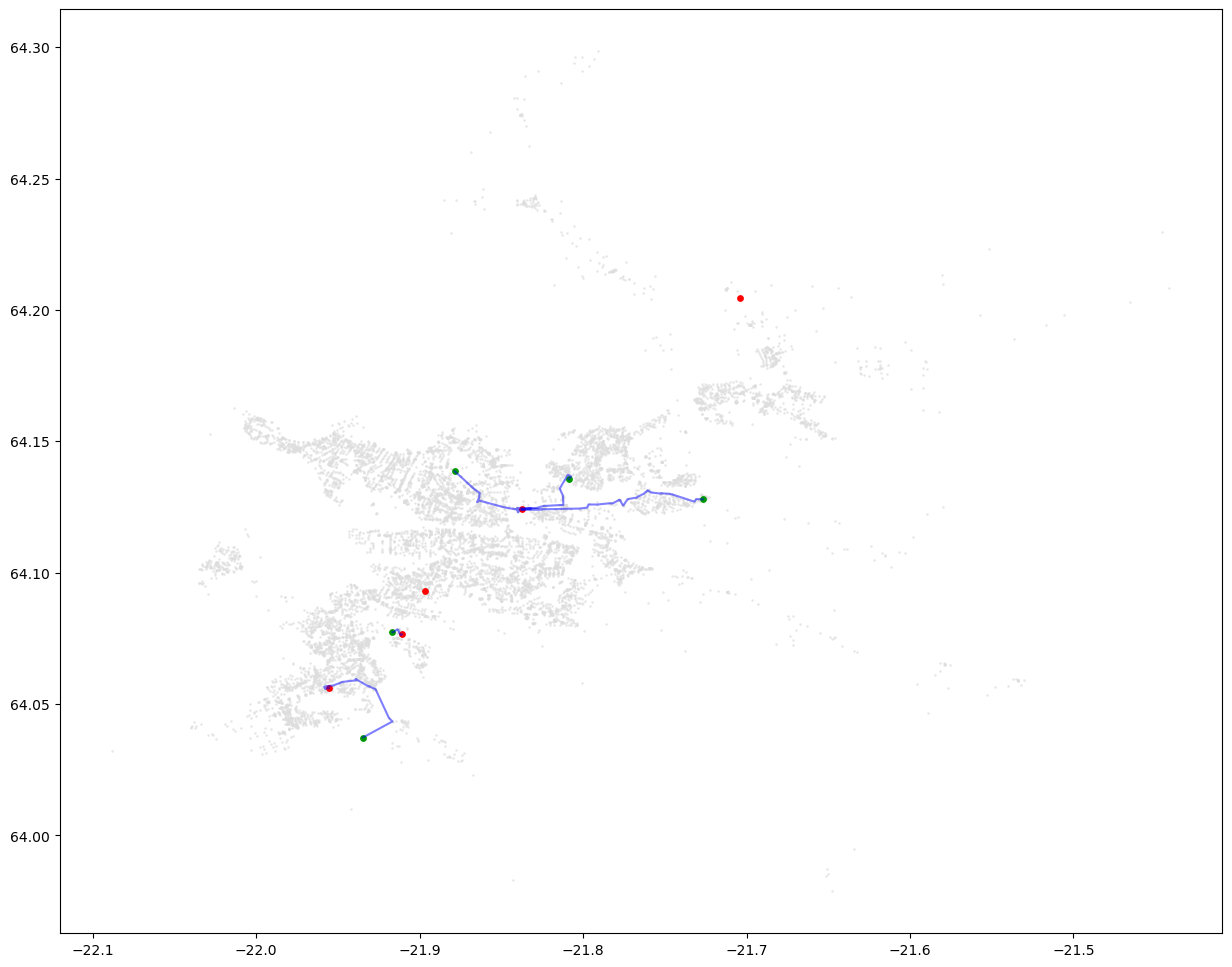

In [125]:
def draw_shortest_paths(starting_positions, stations, starting_position_paths=None):
    if starting_position_paths is None:
        starting_position_paths = leit(starting_positions)

    navigations = []
    for paths in starting_position_paths:
        navigations.append((find_closest_station(paths, stations)))

    plt.figure(figsize=(15, 12))

    for _,_,path in navigations: 
        route = find_route(path)
        plt.plot(route[:, 0],route[:, 1], c='blue', alpha=0.5)

    plt.scatter(df_nodes['x'], df_nodes['y'], c='#dddddd', s=1, alpha=0.5)
    plt.scatter(starting_positions['x'], starting_positions['y'], c='#009900', s=15, alpha=1)
    plt.scatter(stations['x'], stations['y'], c='#ff0000', s=15, alpha=1)
    plt.show()

draw_shortest_paths(starting_positions, stations, starting_position_paths=starting_position_paths)